In [1]:
# import tensorflow as tf
# sess = tf.Session()
import itertools
import keras
from keras import backend as K
# K.set_session(sess)
import h5py

from keras.models import Model
from keras.layers import Dense, LSTM, Input, Embedding, GRU, Masking, Dropout, Lambda, Flatten, concatenate, Conv1D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing.sequence import pad_sequences

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm

# import pandas 

from process_data import *
from model_saving import load_model
import os
# from n_gram_lm import *
import librosa
import kenlm

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16688641422960043501
]


In [3]:
# Problem parameters
max_input_len = 500
max_label_len = 180
max_ratio = 7
n_energies = 20
n_phonemes = 39+1 # 39 phonemes, 1 blank
blank_idx = n_phonemes - 1
blank_idx = n_phonemes - 1

In [4]:
model_name = "densenet_phon_nospace_b3.l5.f128.k7.relu"

In [5]:
model, highest_epoch = load_model(model_name, mode="best")

Loading model densenet_phon_nospace_b3.l5.f128.k7.relu
Compiling...
Looking for weight files with mode "best"
File densenet_phon_nospace_b3.l5.f128.k7.relu-8-41.4200063095.hdf5 contains weights after 8 epochs achieving validation loss: 41.4200063095
File densenet_phon_nospace_b3.l5.f128.k7.relu-13-38.06016676.hdf5 contains weights after 13 epochs achieving validation loss: 38.06016676
File densenet_phon_nospace_b3.l5.f128.k7.relu-16-38.9010786096.hdf5 contains weights after 16 epochs achieving validation loss: 38.9010786096
File densenet_phon_nospace_b3.l5.f128.k7.relu-1-63.4348470576.hdf5 contains weights after 1 epochs achieving validation loss: 63.4348470576
File densenet_phon_nospace_b3.l5.f128.k7.relu-3-53.978602621.hdf5 contains weights after 3 epochs achieving validation loss: 53.978602621
File densenet_phon_nospace_b3.l5.f128.k7.relu-4-47.3478324621.hdf5 contains weights after 4 epochs achieving validation loss: 47.3478324621
File densenet_phon_nospace_b3.l5.f128.k7.relu-0-81.0

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
mfccs (InputLayer)               (None, 500, 20)       0                                            
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 500, 128)      18048       mfccs[0][0]                      
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 500, 128)      512         conv1d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 500, 128)      0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [7]:
# inputs, outputs, ids = get_test_data(n_phonemes, max_label_len, max_input_len)

# # print inputs_valid.keys()
# X = inputs["mfccs"]
# input_lengths= inputs["input_lens"]
# y= inputs["labels"]
# label_lengths= inputs["label_lens"]
D = nltk.corpus.cmudict.dict()

# label = code_label("what is the phone number", D)
wave_files = ["akuan_phone_number.wav.1","peter_phone_number.wav.1"]

mfccs = []
labels = []
label_lens = []
input_lens = []

for path in wave_files:
    wave, sr = librosa.load(path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sr=16000).T # transpose because librosa returns with time axis last instead of first
    label = code_label("what is the phone number", D)
    label_len = len(label)
    input_len = mfcc.shape[0]
    labels.append(label) 
    mfccs.append(mfcc) 
    label_lens.append(label_len) 
    input_lens.append(input_len)
input_lens = np.asarray(input_lens)
label_lens = np.asarray(label_lens)

In [8]:

y = keras.preprocessing.sequence.pad_sequences(labels, 
                                                           maxlen=max_label_len, 
                                                           dtype='int32',
                                                           padding='post', 
                                                           truncating='post', 
                                                           value=-1)
X = keras.preprocessing.sequence.pad_sequences(mfccs, 
                                               maxlen=max_input_len, 
                                               dtype='float32',
                                               padding='post', 
                                               truncating='post', 
                                               value=0.)
inputs = {'mfccs': X,
      'labels': y,
      'input_lens': np.asarray(input_lens),
      'label_lens': np.asarray(label_lens)}

In [14]:

ctc_costs, phoneme_probs = model.predict(inputs)
print np.mean(ctc_costs)
sample = phoneme_probs[0, :input_lens[0]]
print sample

17.2006
[[  7.24258825e-06   1.82294098e-05   7.07003492e-05 ...,   5.13060695e-05
    1.13199228e-07   9.98108983e-01]
 [  3.39145590e-05   5.21910442e-05   1.07139123e-04 ...,   7.91624461e-06
    8.29175928e-09   9.98802781e-01]
 [  2.76470546e-05   1.00591269e-05   7.11629182e-05 ...,   3.15317993e-05
    3.95454514e-08   9.99078512e-01]
 ..., 
 [  7.36946006e-08   7.46229432e-07   3.32463969e-06 ...,   2.40158670e-06
    7.31329663e-08   9.99774754e-01]
 [  1.21532224e-07   3.80972642e-06   2.31471472e-06 ...,   6.60706337e-06
    1.69176786e-07   9.99795735e-01]
 [  6.42171116e-08   3.18352841e-06   3.97072199e-06 ...,   7.01492309e-06
    5.52374217e-08   9.99806345e-01]]


In [15]:
np.save("../decoder/phoneme_probs", sample)

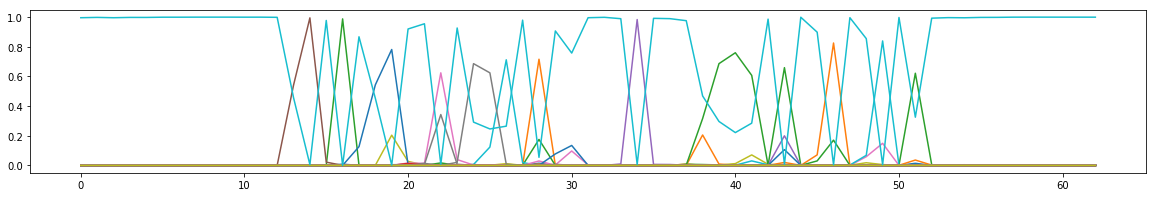

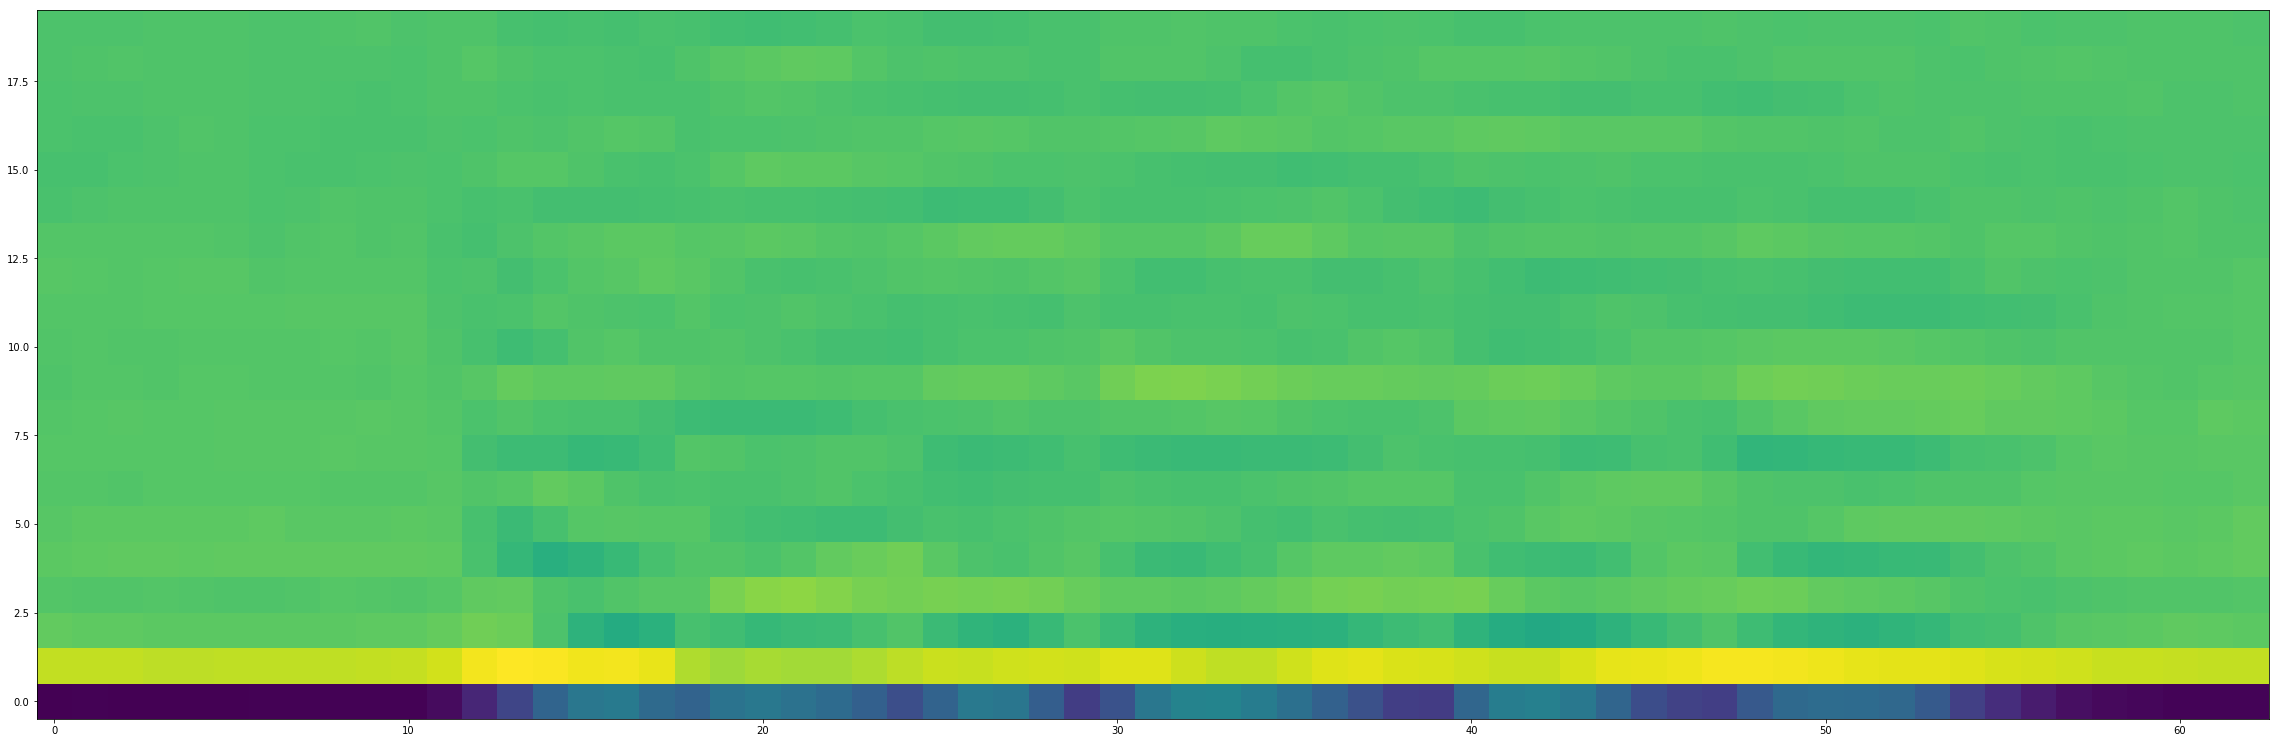

In [12]:
checking_idx = 1
#sample_id = ids[checking_idx]

sample_probs = phoneme_probs[checking_idx]
sample_input_length = input_lens[checking_idx]
sample_label_length = label_lens[checking_idx]
sample_X = X[checking_idx]

plt.figure(figsize=(20,3))
plt.plot(sample_probs[:sample_input_length]);
fig, ax = plt.subplots(figsize=(40,100))
mfcc_data= np.swapaxes(sample_X[:input_lens[checking_idx], ], 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest' , origin='lower')


In [13]:
# print "Sample id: {}".format(sample_id)
print
# Try the argmax acoustic-only decoder
print "Argmax phonemes:"
phonemes = interpret_probs(sample_probs[:sample_input_length], ignore_blanks = False)
print "".join([x for x in phonemes if x!="-"])
# Print the 'actual' text
print


print "Actual text :"
phonemes =  obtain_phonemes("what is the phone number".split(), D)
print "".join(phonemes)
# 6319-275224-0019.flac

print "Normalized loss:"
print ctc_costs[checking_idx]


Argmax phonemes:
WAHTIHZDHAEOWNAHMDHAH

Actual text :
WAHTIHZDHAHFOWNNAHMBER
Normalized loss:
[ 16.35684586]


In [39]:
phoneme_probs.shape

(2, 500, 40)

In [47]:
import tensorflow as tf

phoneme_probs_ = K.variable(phoneme_probs)#K.placeholder((None, max_input_len, n_phonemes), name="phoneme_probs")
input_lens_ = K.variable(input_lens)#K.placeholder(name='input_length',shape=(None, 1), dtype='int64')
top_paths, logp = K.ctc_decode(y_pred=phoneme_probs_, 
                               input_length=input_lens_, 
                               greedy=False, 
                               beam_width=10**4, 
                               top_paths=1000)

# print X_.shape
# print input_lengths_.shape
sess = tf.Session()
sess.run(tf.global_variables_initializer())
P, L = sess.run([top_paths,logp])

In [48]:
L

array([[ 2.17926192,  2.13937426,  1.77027333, ..., -1.07142973,
        -1.07148933, -1.07177651],
       [ 2.17926192,  2.13937426,  1.77027333, ..., -1.07142973,
        -1.07148933, -1.07177651]], dtype=float32)

In [49]:
np.savez("../1k_paths", *P)

In [39]:
sample_id

'2961-960-0017.flac'

In [44]:
P_check = P[0][checking_idx]
print P_check.shape
phon_check = code_to_phonemes([x for x in P_check if x!=-1])
# print phon_check
# assert phon_check == [x for x in phonemes if x!="-"]
print "".join([x for x in phon_check if x!="-"])
print "".join([x for x in phonemes if x!="-"])

IndexError: index 1 is out of bounds for axis 0 with size 1

In [75]:
cmudict = nltk.corpus.cmudict.dict()
language = cmudict.keys()

In [76]:
cmudict["don't"]

[[u'D', u'OW1', u'N', u'T'], [u'D', u'OW1', u'N']]

In [48]:
n_paths = 100
alpha = 1.25
beta = 0.1            
step_size = 5
candidates = beam_search_word(sample_probs, sample_input_length, language_score, alpha, beta, n_paths, step_size)

Starting beam search with input of length 258 ...
Reached t = 0
Found top 100 candidates
Checking extensions of "" which has current score 0.0
[u'fawn']
[u'F', u'AO', u'N']


AttributeError: 'list' object has no attribute 'shape'